In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
import os 

import sys
sys.path.append("C:/Users/tyrab/tyler_python/interview_prep/")
sys.path.append("C:/Users/tyrab/tyler_python/futures_trading/")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install pytrends

  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16109 sha256=76acc48f0e2606566563bbc377c04093e8d9de2213a89d6c57d267cbb6da1e69
  Stored in directory: c:\users\tyrab\appdata\local\pip\cache\wheels\07\6f\5c\8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends


In [3]:
from pytrends.request import TrendReq

# NOTE: TX = -300 is EST
pytrends = TrendReq(hl='en-US', tz=-300) 

C:\Users\tyrab\AppData\Roaming\Python\Python37\site-packages\cryptography\hazmat\backends\openssl\x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [4]:
# Searching for Angi on Google Trends Data
kw_list = ["angi"]

pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m') 

In [37]:
df = pytrends.get_historical_interest(kw_list, year_start=2022, month_start=1, day_start=1, hour_start=0, year_end=2022, month_end=4, day_end=16, hour_end=0, cat=0, sleep=0)

C:\Users\tyrab\AppData\Roaming\Python\Python37\site-packages\cryptography\hazmat\backends\openssl\x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [40]:
df = df.reset_index()
df = df.rename(columns={'date': 'timestamp', 'angi': 'N'})
df = df[['timestamp', 'N']]
df['date'] = df.timestamp.dt.date
df['time'] = df.timestamp.dt.time
df = df[['date', 'time', 'N']]
df.columns = df.columns.str.upper()

In [33]:
df_hourly.head()

,date,angi,isPartial
0,2022-01-01 00:00:00,0,False
1,2022-01-01 01:00:00,25,False
2,2022-01-01 02:00:00,100,False
3,2022-01-01 03:00:00,0,False
4,2022-01-01 04:00:00,0,False


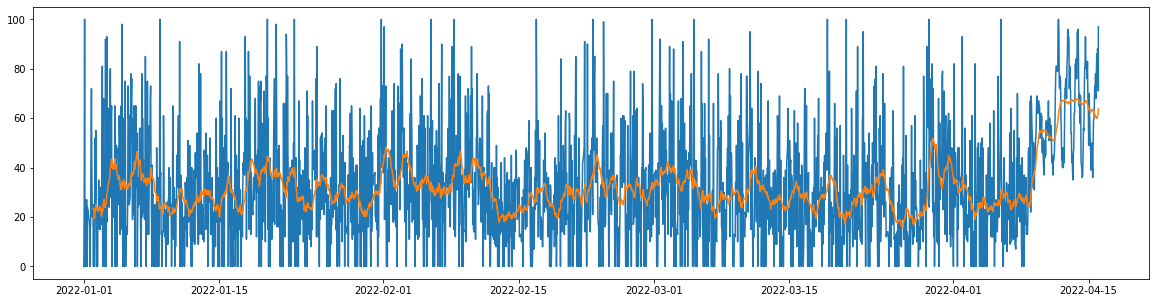

In [34]:
plt.figure(figsize=(20,5))
plt.plot(df_hourly.date, df_hourly.angi)
plt.plot(df_hourly.date, df_hourly.angi.rolling(24).mean())

<BarContainer object of 24 artists>

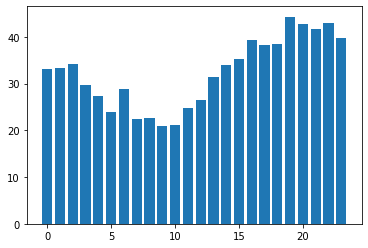

In [35]:
df_gr = df_hourly.groupby(df_hourly.date.dt.hour).angi.mean().reset_index()
plt.bar(df_gr.date, df_gr.angi)

In [10]:
import datetime

In [11]:
curr_time = datetime.datetime.now()
prev_day = curr_time+datetime.timedelta(days=-1)

In [12]:
prev_day.hour

17

In [25]:
def get_hourly_data(kw_list, year, month, day):
    df = pytrends.get_historical_interest(kw_list, year_start=year, month_start=month, day_start=day, hour_start=0, year_end=year, month_end=month, day_end=day, hour_end=23, cat=0, sleep=0)
    df = df.reset_index()
    df = df.rename(columns={'date': 'timestamp', 'angi': 'N'})
    df = df[['timestamp', 'N']]
    df['date'] = df.timestamp.dt.date
    df['time'] = df.timestamp.dt.time
    df = df[['date', 'time', 'N']]
    df.columns = df.columns.str.upper()
    
    return df

def get_hourly_data2(kw_list, year, month, day ,hour):
    df = pytrends.get_historical_interest(kw_list, year_start=year, month_start=month, day_start=day, hour_start=hour, year_end=year, month_end=month, day_end=day, hour_end=hour, cat=0, sleep=0)
    df = df.reset_index()
    df = df.rename(columns={'date': 'timestamp', 'angi': 'N'})
    df = df[['timestamp', 'N']]
    df['date'] = df.timestamp.dt.date
    df['time'] = df.timestamp.dt.time
    df = df[['date', 'time', 'N']]
    df.columns = df.columns.str.upper()
    
    return df

In [174]:
df = get_hourly_data(kw_list, 2021, 4, 16)

In [86]:
!pip install schedule

## OK - we want to query Google Trends every day and get the historical hourly data for searches for "Angi" for the previous day
### Then we will write into our Snowflake database we created

In [14]:
df.dtypes

angi         int32
isPartial     bool
dtype: object

In [15]:
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas

In [16]:
con = snowflake.connector.connect(
    user='XXXX',
    password='XXXX',
    account='bc44100.us-east-2.aws'
)

#Create a database to store my data
con.cursor().execute("CREATE DATABASE IF NOT EXISTS google_data")
con.cursor().execute("USE DATABASE google_data")

In [29]:
create_table = 'CREATE OR REPLACE TABLE ANGI_GOOGLE_TRENDS (\nDATE DATE, \nTIME TIME,\nN INT)'

In [18]:
# Create the empty table in snowflake with specified data types
# con.cursor().execute('DROP TABLE ANGI_GOOGLE_TRENDS')

In [30]:
# Create the empty table in snowflake with specified data types
con.cursor().execute(create_table)

In [41]:
# Write Data to Snowflake.
success, nchunks, nrows, _ = write_pandas(con, df, table_name='ANGI_GOOGLE_TRENDS')

In [44]:
nrows

2536

In [21]:
import schedule
import time
import datetime

In [22]:
def job_to_run_daily():
    
    kw_list = ["angi"]
    curr_time = datetime.datetime.now()
    prev_day = curr_time+datetime.timedelta(days=-1)
    df = get_hourly_data(kw_list, prev_day.year, prev_day.month, prev_day.day)
    success, nchunks, nrows, _ = write_pandas(con, df, table_name='ANGI_GOOGLE_TRENDS')
    print(success)
    
    return 
    

In [23]:
def job_to_run_hourly():
    
    kw_list = ["angi"]
    curr_time = datetime.datetime.now()
    prev_day = curr_time+datetime.timedelta(days=-1)
    df = get_hourly_data2(kw_list, prev_day.year, prev_day.month, prev_day.day, prev_day.hour)
    success, nchunks, nrows, _ = write_pandas(con, df, table_name='ANGI_GOOGLE_TRENDS')
    print(success)
    
    return 
    

In [27]:
schedule.every().day.at("19:25").do(job_to_run_daily)

while True:
    schedule.run_pending()
    time.sleep(60) # wait one minute

In [28]:
# schedule.every().hour.do(job_to_run_hourly)
# while True:
#     schedule.run_pending()
#     time.sleep(60) # wait one minute